## Задача

#### Обучите модель линейной регрессии на найденных двумя способами трёх важных признаках и сравните полученные результаты:
- выделены три столбца-признака для обучения, выбранные RFE.
- выделены три столбца-признака для обучения, выбранные SelectKBest.
- обучена регрессия на первых трёх столбцах, оценено качество модели на тесте.
- обучена регрессия на вторых трёх столбцах, оценено качество модели на тесте.
- ответ на вопрос «Какой метод отбора признаков показал наилучший результат на тестовой выборке?»

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression


# Загрузка данных

In [74]:
data = pd.read_excel('data/data_ford_price.xlsx') 

In [75]:
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


# Предобработка данных

In [45]:
# Предобработка данных
data = data[['price','year', 'cylinders', 'odometer', 'lat', 'long', 'weather']]
data.dropna(inplace = True)

y = data['price']
x = data.drop(columns='price')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

## Обучение предсказание на baseline

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4682.957


# Отбор признаков и предсказания

<AxesSubplot: >

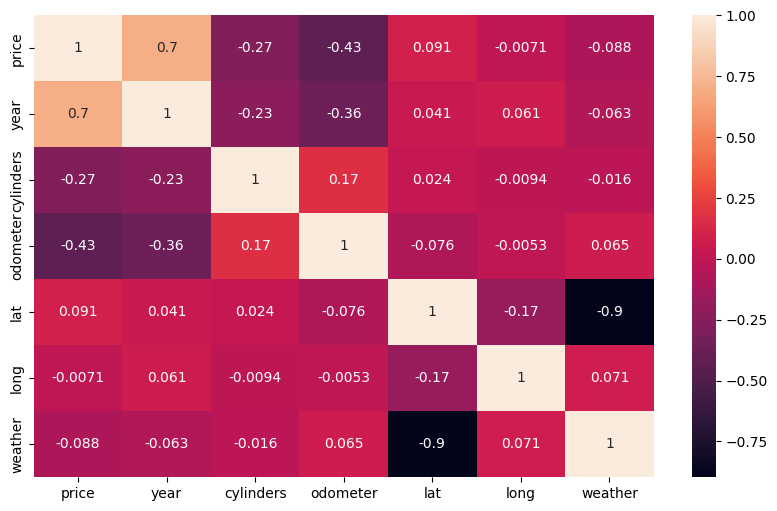

In [71]:
# Посмотрим на корреляцию признаков между собой и целевой переменной
plt.figure(figsize= (10, 6))
sns.heatmap(data.corr(), annot=True)

### Метод рекурсивного исключения признаков (RFE)

In [68]:
selector_rfe = RFE(LinearRegression(), n_features_to_select=3, step=1)
selector_rfe.fit(X_train, y_train)
 
сol_rfe = selector_rfe.get_feature_names_out()
сol_rfe

array(['year', 'cylinders', 'lat'], dtype=object)

In [48]:
X_train_rfe = X_train[сol_rfe]
X_test_rfe = X_test[сol_rfe]

In [73]:
# Обучаем модель на трэйне, делаем предсказание на тестовой выборке и оцениваем качество предсказаний метрикой MAE

model.fit(X_train_rfe, y_train)
y_predicted_rfe = model.predict(X_test_rfe)
 
mae_rfe = mean_absolute_error(y_test, y_predicted_rfe)
print('MAE: %.2f' % mae_rfe)

MAE: 5096.57


### Метод выбора k лучших переменных

In [69]:
selector_kb = SelectKBest(f_regression, k=3)
selector_kb.fit(X_train, y_train)
 
сol_kb = selector_kb.get_feature_names_out()
сol_kb

array(['year', 'cylinders', 'odometer'], dtype=object)

In [56]:
X_train_kb = X_train[сol_kb]
X_test_kb = X_test[сol_kb]

In [72]:
# Обучаем модель на трэйне, делаем предсказание на тестовой выборке и оцениваем качество предсказаний метрикой MAE

model.fit(X_train_kb, y_train)
y_predicted_kb = model.predict(X_test_kb)
 
mae_kb = mean_absolute_error(y_test, y_predicted_kb)
print('MAE: %.2f' % mae_kb)

MAE: 4708.95


**Выводы:**

Метод одномерного выбора показал лучшее качество модели, чем рекурсивное исключение, хотя отличие между тройками отобранных признаков минимально. Это можно объяснить и наглядно показать на тепловой карте матрицы корреляции признаков и таргета. Видно, что отобранне методом RFE значения географической широты ("lat") имеют очень слабую связь с уелевой переменной, то есть никак не влияют на неё, а, следовательно, обучение мождели проходит только на двух признаках. Тогда как отобранный методом k-лучших столбец с пробегом ("odometr") оправданно влияет на цену автомобиля
